This Jupyter Notebook runs a series of experiments related to various real-world datasets. The analysis evaluates statements using statistical methods and different support constraints. Each experiment prints its results, providing insights into different phenomena.

### On Detecting Cherry-Picked Trendlines

# Introduction

Cherry-picking data to misrepresent trends is a common issue in data analysis. This is particularly problematic when drawing trendlines from time-series or relational data, as selective endpoints can create misleading narratives. The paper *On Detecting Cherry-picked Trendlines* introduces methods to quantify and detect cherry-picking by computing the *support* of a given trendline statement.

The fundamental idea is to determine how representative a given trendline is by comparing it to alternative trendlines that could be drawn from the same dataset. If a trendline is significantly different from most possible alternatives, it is likely cherry-picked.

This document explains and presents implementations of the core algorithms proposed in the paper:

- **Baseline and Exact Methods for Unconstrained Trendlines**
- **Baseline and Exact Methods for Constrained Trendlines**
- **Monte Carlo Sampling for Efficient Approximation**
- **Optimizing Statements: Tightest and Most Supported Trendlines**

## 1. Baseline Unconstrained Algorithm

This algorithm calculates the support of a statement by performing a brute-force evaluation of all valid trendlines. It iterates through all pairs of points in the dataset, verifying whether the difference in their target attribute values falls within the given statement bounds.

**Definition**: Given two disjoint regions of interest in the dataset, `left_region` (minuend) and `right_region` (subtrahend), and a function `quantifier` that extracts a numerical value from records, the *support* of a statement $(\text{lower}, \text{upper})$ is computed as:

$$
\omega(S) = \frac{\text{\# of valid pairs satisfying } \text{(lower} < f(x_1) - f(x_2) < \text{upper)} }{\text{Total pairs}}
$$

**Complexity**: $O(n^2)$

---

## 2. Exact Unconstrained Algorithm

The brute-force approach is inefficient for large datasets. Instead, we use **sorted cumulative values** to enable efficient counting via binary search.

- We first compute all $f(x_1)$ values from `left_region` and sort them.
- Then, for each $x_2$ in `right_region`, we determine how many $x_1$ values satisfy the condition using `searchsorted`, which allows $O(\log n)$ lookup time.

This improves performance from $O(n^2)$ to **$O(n \log n)$**.

---

## 3. Baseline Constrained Algorithm

The constrained setting introduces additional restrictions on which pairs are considered valid, defined by a function $constraints(x_1, x_2)$. This is a stricter setting where not all pairs in `left_region` $\times$ `right_region` are valid.

- Instead of iterating over all pairs, we first filter `right_region` dynamically for each $x_1$ to exclude invalid pairs.
- The remaining pairs are evaluated against the `statement` bounds.

**Complexity**: $O(n^2)$ in the worst case but may be lower depending on the constraint function.

---

## 4. Exact Constrained Algorithm (Using Red-Black Tree)

Since filtering valid pairs dynamically is expensive, we improve efficiency using an **Order Statistics Red-Black Tree (RBT)**:

- The RBT efficiently maintains and updates the set of valid $x_1$ values as we iterate over `right_region`.
- We use **count_smaller_than()** to efficiently count values that satisfy the statement.

This brings down the worst-case complexity to **$O(n \log n)$**.

---

## 5. Monte Carlo Pair Sampling (Approximate Support Computation)

To further improve efficiency, we use **Monte Carlo Sampling**, which approximates support using randomly selected valid pairs.

### **Method**
1. Randomly sample $n$ pairs from `left_region` $\times$ `right_region`.
2. Check if the sampled pairs satisfy the statement.
3. Compute the estimated support as the proportion of valid samples.

$$
\hat{\omega}(S) = \frac{\text{\# of valid sampled pairs}}{n}
$$

4. Compute an error bound using the **Normal approximation**:

$$
\epsilon = Z_{\alpha/2} \cdot \sqrt{\frac{\hat{\omega} (1-\hat{\omega})}{n}}
$$

where $Z_{\alpha/2}$ is the critical value from the normal distribution.

**Complexity**: $O(n)$, where $n$ is the number of sampled pairs.

---

## 6. Monte Carlo Point Sampling (Alternative Approximation)

Instead of sampling pairs, **point sampling** independently selects $n$ values from `left_region` and `right_region` and evaluates all possible pairs between them.

- This results in $O(n^2)$ samples but provides a tighter confidence interval.
- A sorted list is used for efficient counting, reducing complexity to $O(n \log n)$.

---

## 7. Finding the Most Supported Statement (MSS)

Given a fixed range width $d$, we want to find the **(low,high)** interval that maximizes support.

### **Approach**
- Compute the **sorted distribution of trendline differences**.
- Use a **sliding window** to find the most frequent interval of width $d$.
- The support of the most frequent interval is the **highest attainable support**.

**Complexity**: $O(n^2 \log n)$.

---

## 8. Finding the Tightest Statement (TS)

Instead of maximizing support, **we minimize the width of (low,high) while maintaining a fixed support level $s$**.

- Sort all valid differences.
- Use a **sliding window** approach to find the smallest range that retains at least $s$ fraction of the trendlines.

This identifies the **most conservative** yet well-supported statement.

**Complexity**: $O(n^2 \log n)$.

## Summary of Algorithmic Tradeoffs

| Algorithm                 | Complexity      | Key Features |
|---------------------------|-----------------|--------------|
| **Baseline Unconstrained** | $O(n^2)$        | Brute force comparison |
| **Exact Unconstrained** | $O(n \log n)$   | Uses sorting and binary search |
| **Baseline Constrained** | $O(n^2)$        | Adds constraint filtering |
| **Exact Constrained (RBT)** | $O(n \log n)$   | Maintains efficient updates |
| **Monte Carlo Pair Sampling** | $O(n)$          | Approximate, efficient |
| **Monte Carlo Point Sampling** | $O(n \log n)$   | More accurate estimates |
| **Most Supported Statement (MSS)** | $O(n^2 \log n)$ | Finds best interval of width $d$ |
| **Tightest Statement (TS)** | $O(n^2 \log n)$ | Finds smallest valid interval |


## Conclusion

Detecting cherry-picked trendlines requires robust statistical and algorithmic methods. The algorithms presented balance **efficiency** (for large datasets) and **accuracy** (to avoid misleading interpretations).

- **Exact algorithms** provide deterministic correctness.
- **Monte Carlo methods** enable fast approximations with error bounds.
- **Optimized statement search** provides better alternatives to misleading trends.

These methods form the foundation for **automated detection of misleading data visualizations**, ensuring greater transparency in data-driven storytelling.

# Section 1: Paper Algorithms - Experiments On Real-World Datasets

## 1.1 Beer Sheva Temperature Experiment

In [1]:
import experiments

This experiment checks whether Beer-Sheva's summer is significantly hotter than its winter.
The analysis includes both unconstrained and constrained comparisons of temperature distributions.

In [2]:
experiments.beer_sheva_temps()

Statement: In Beer-Sheva the summer is hotter than the winter
Baseline Unconstrained: 99.83%
Exact Unconstrained: 99.83%
Point Sampling Unconstrained: 99.76%
Tightest Statement (at least 95% support): (5.5, 20.9)


## 1.2 Dead Sea Level Experiment

This experiment examines whether the Dead Sea level has been rising since 1991.
The dataset contains sea level measurements from before and after 1991.

In [3]:
experiments.dead_sea_level()

Statement: Since 1991 the Dead Sea level is on the rise
Baseline Unconstrained: 0.69%
Exact Unconstrained: 0.69%
Point Sampling Unconstrained: 0.67%
Most Supported Statement (for 30 meters difference): Statement=(-34.94999999999999, -4.949999999999989), Support=87.68%


## 1.3 African GDP Experiment

This experiment evaluates the impact of the 2008 financial crisis on African countries' GDP.
It compares GDPs of African countries in 2008 and 2009, considering country-wise constraints.

In [4]:
experiments.african_gdp()

Statement: African countries did not suffer from the great recession of 2008, i.e. their GDP did not decreased from 2008 to 2009
Baseline Constrained: 57.58%
Exact Constrained: 57.58%
Pair Sampling Constrained: Support=57.81%, Error Margin=0.07%
Tightest Statement (at least 95% support): (-13623000000.0, 30067000000.0)
Most Supported Statement(for 1B$ difference): Statement=(-286343739.0, 708122133.0), Support=42.42%


## 1.4 Germany Rainfall Experiment

This experiment analyzes rainfall similarities between Düsseldorf and Berlin.
It ensures comparisons are made for the same months and years.

In [3]:
experiments.germany_rainfall()

Statement: Dusseldorf and Berlin has approximately the same rain (up to 2.5mm difference) amount for the same month.
Baseline Constrained: 2.78%
Exact Constrained: 2.78%
Pair Sampling Constrained: Support=2.31%, Error Margin=0.03%
Most Supported Statement (for 30mm difference): Statement=(-46.620000000000005, -16.759999999999998), Support=19.44%


## 1.5 Danish House Pricing Experiment


This experiment examines whether house prices in Denmark remain consistent
within the same city, quarter, and number of rooms.

In [3]:
experiments.danish_house()

Statement: In Denmark the prices of old (built before 1900) house are higher than new houses (built from 1900).
Point Sampling Unconstrained: 49.71%


# Section 2: Graphical Analysis


## 2.1 Tightest Statement per Support Graph


This graph visually represents the tightest statement at various support levels.
It uses a vertical stick graph to show how statements change with different support percentages.

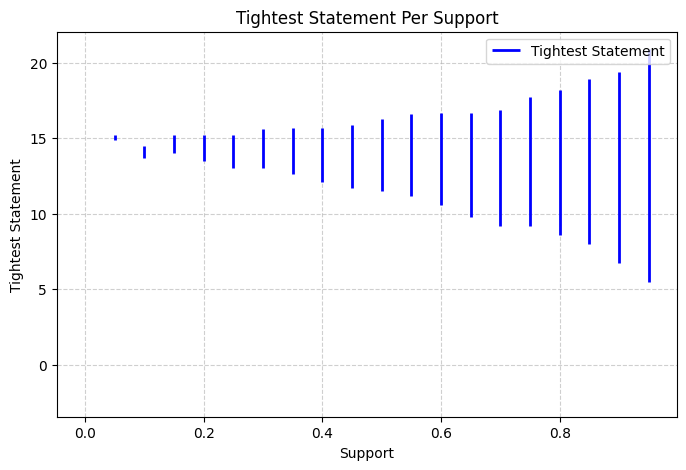

In [6]:
experiments.beer_sheva_temps_ts_graph()

We can see that the statements are overall are contained in each other, i.e. when increasing support we get a larger range (**broader statement**) that is containing the previous one, which makes sense.
We can see that in order to get at least 80% support the tightest statement is a temperatures difference of 8 to 17.

## 2.2 Most Supported Statement per Statement Range Graph


This graph shows the most supported statement for different temperature ranges.
It includes two plots:
 - The first shows statement ranges using vertical sticks.
 - The second shows support levels as red bars.

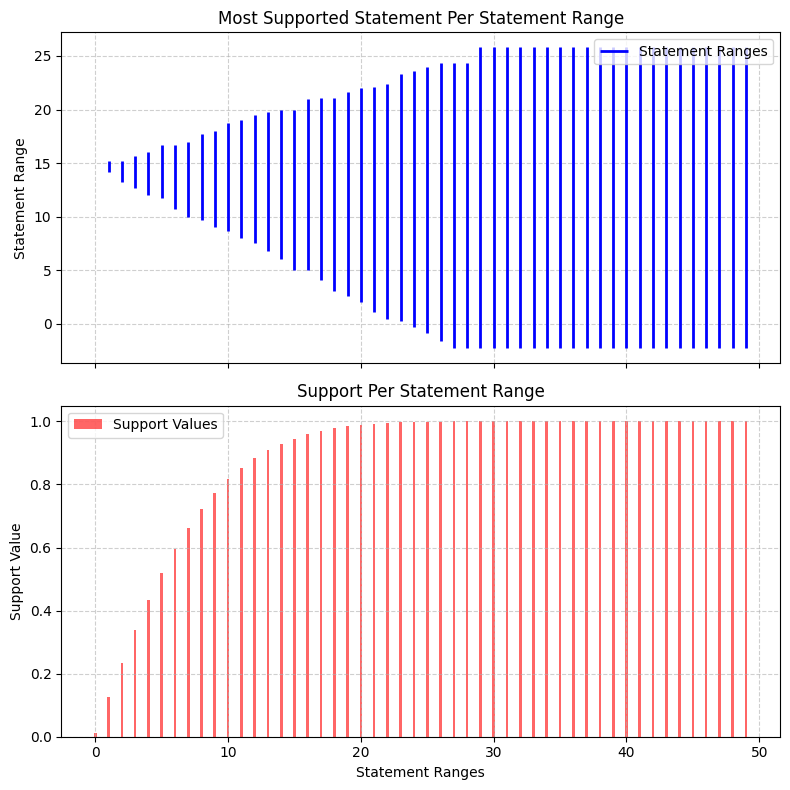

In [7]:
experiments.beer_sheva_temps_mss_graph()

We can see that from a range (difference of temperatures) of 10 degrees the support is at least 80%, and the matching statement is (8,18). From that we can conclude that in Beer Sheva the summer is hotter than the winter in at least 8 degrees and not more than 18 degrees for approximately 80% of the time.

## 2.3 Exact VS Point Sampling Support Accuracy

This graph shows an accuracy comparison between the exact algorithm and its stochastic/Monte Carlo (i.e. "Point Sampling") approach.
The idea was to sample a subset of the data (in increasing size, from 5% up to 100%) and each time calculate exact and point algorithms, while comparing it to the entire accurate support of the full data.
The graph includes 3 parts:
  - Exact support calculated on the full dataset, i.e. the accurate support value.
  - Point Sampling result on a changing size subset
  - Exact result on a changing size subset (same subset as the point calculation)

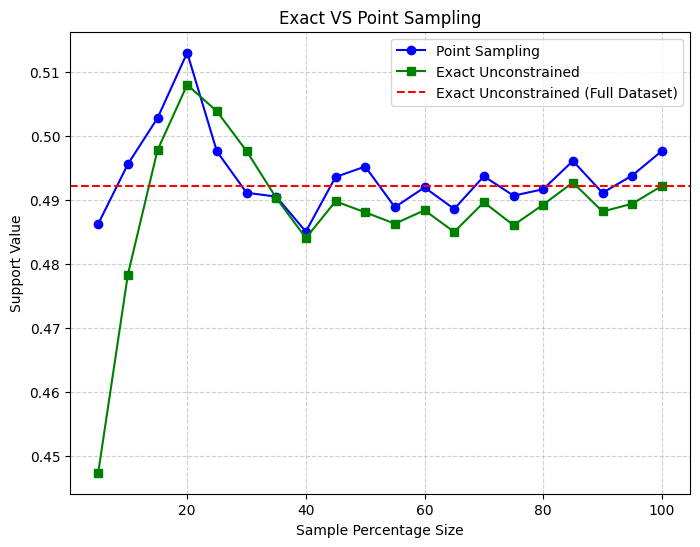

In [2]:
experiments.stochastic_danish_house()

**There's a fascinating insight!**
We can see that for most of the cases, the point sampling was even **closer** to the real (entire dataset) support, rather than the exact calculation!